In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Initializing Metal backend
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Importing dataset
# Data available here : https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
household_power_consumption = pd.read_csv(
    "household_power_consumption.txt",
    sep=";", parse_dates={"datetime": ["Date", "Time"]}, low_memory=False, 
    na_values=["nan", "?"])

# Set datetime as index
household_power_consumption.set_index("datetime", inplace=True)

# Checking for NaN values
household_power_consumption.isna().values.any()

# Filling missing values
household_power_consumption.interpolate(inplace=True)

# Normalizing variables
scaler = MinMaxScaler()
household_pc_scaled = scaler.fit_transform(household_power_consumption)

# Putting normalized data in a DataFrame
household_pc_scaled = pd.DataFrame(household_pc_scaled,
                                   columns=household_power_consumption.columns, 
                                   index=household_power_consumption.index)

# Splitting our sample
household_pc_training = household_pc_scaled.sample(frac=0.8, random_state=123456)
household_pc_validation = household_pc_scaled.drop(household_pc_training.index)

# Creating sequences for time-series forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]["Global_active_power"]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Generating the sequences
seq_n = 24
X_train, y_train = create_sequences(household_pc_training, seq_n)
X_test, y_test = create_sequences(household_pc_validation, seq_n)

# Converting data to PyTorch tensors
X_train_tensors = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32).to(device)

# Creating data loaders
hh_pc_train = TensorDataset(X_train_tensors, y_train_tensors)
hh_pc_test = TensorDataset(X_test_tensors, y_test_tensors)
train_loader = DataLoader(hh_pc_train, batch_size=64, shuffle=True)
test_loader = DataLoader(hh_pc_test, batch_size=64, shuffle=False)

/var/folders/h1/hrjhnsw55w3fh7wq8fc7_bcm0000gn/T/ipykernel_16679/1453496960.py:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  household_power_consumption = pd.read_csv(


In [22]:
from torch.optim.lr_scheduler import StepLR

# Model construction
class EnergyConsumptionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EnergyConsumptionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  # Combine RNN and LSTM outputs

    def forward(self, x):
        h0_gru = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.gru(x, h0_gru)
        gru_out = gru_out[:, -1, :]
        
        h0_lstm = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0_lstm = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0_lstm, c0_lstm))
        lstm_out = lstm_out[:, -1, :]
        
        out = torch.cat((gru_out, lstm_out), dim=1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        
        return out

# Model specifications
hidden_size = 64
output_size = 1
num_layers = 3

# Initialization
model = EnergyConsumptionModel(X_train.shape[2], hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size = 4, gamma = 0.2)

# Model training
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")
        scheduler.step(avg_loss)

train_model(model, train_loader, criterion, optimizer, scheduler, epochs=20)


Epoch 1/20, Loss: 0.009108073888681515


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


KeyboardInterrupt: 

Test MSE: 0.009085719473659992


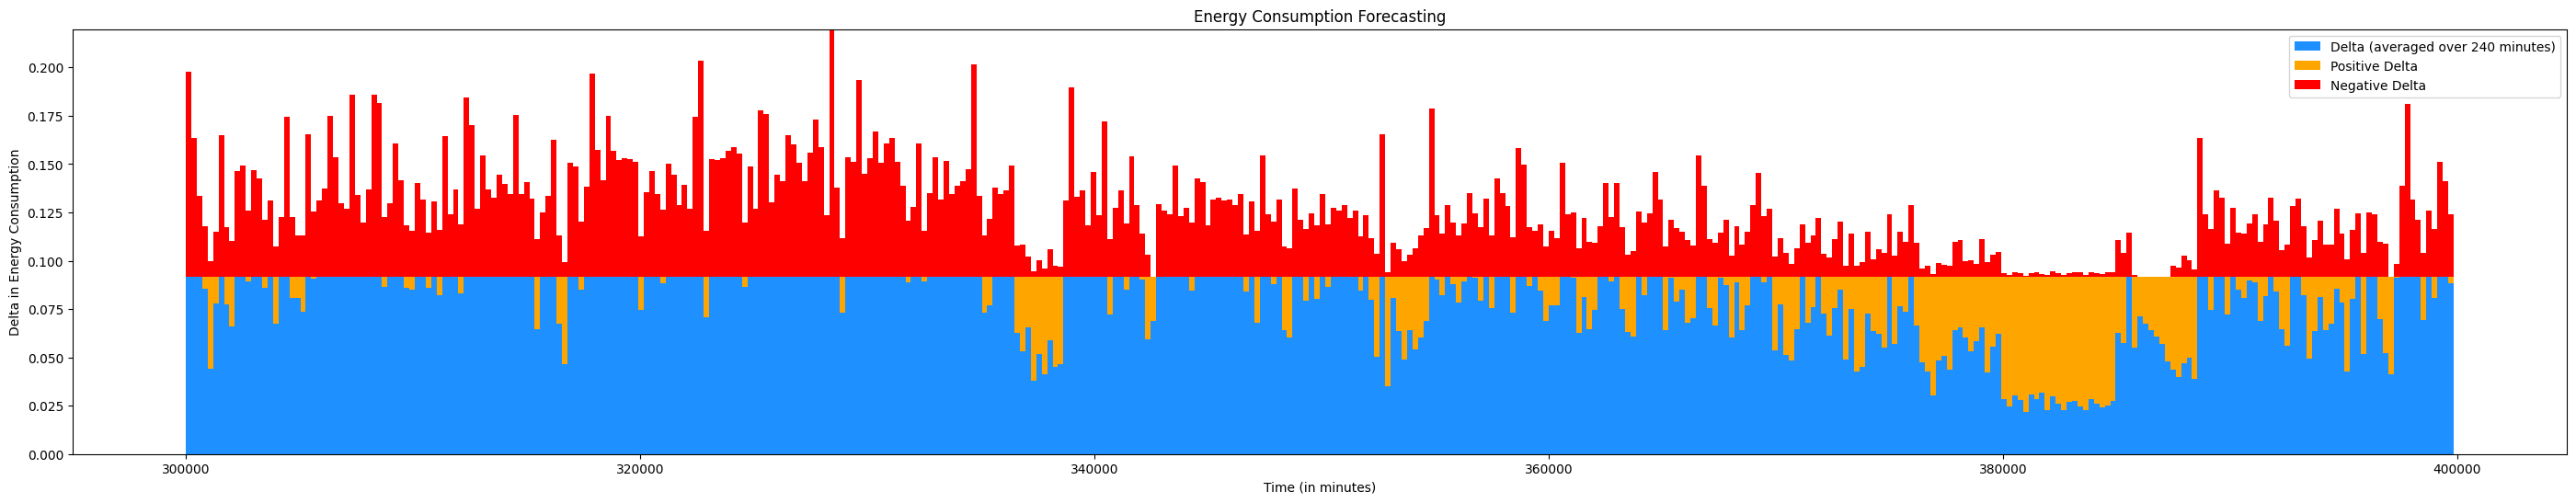

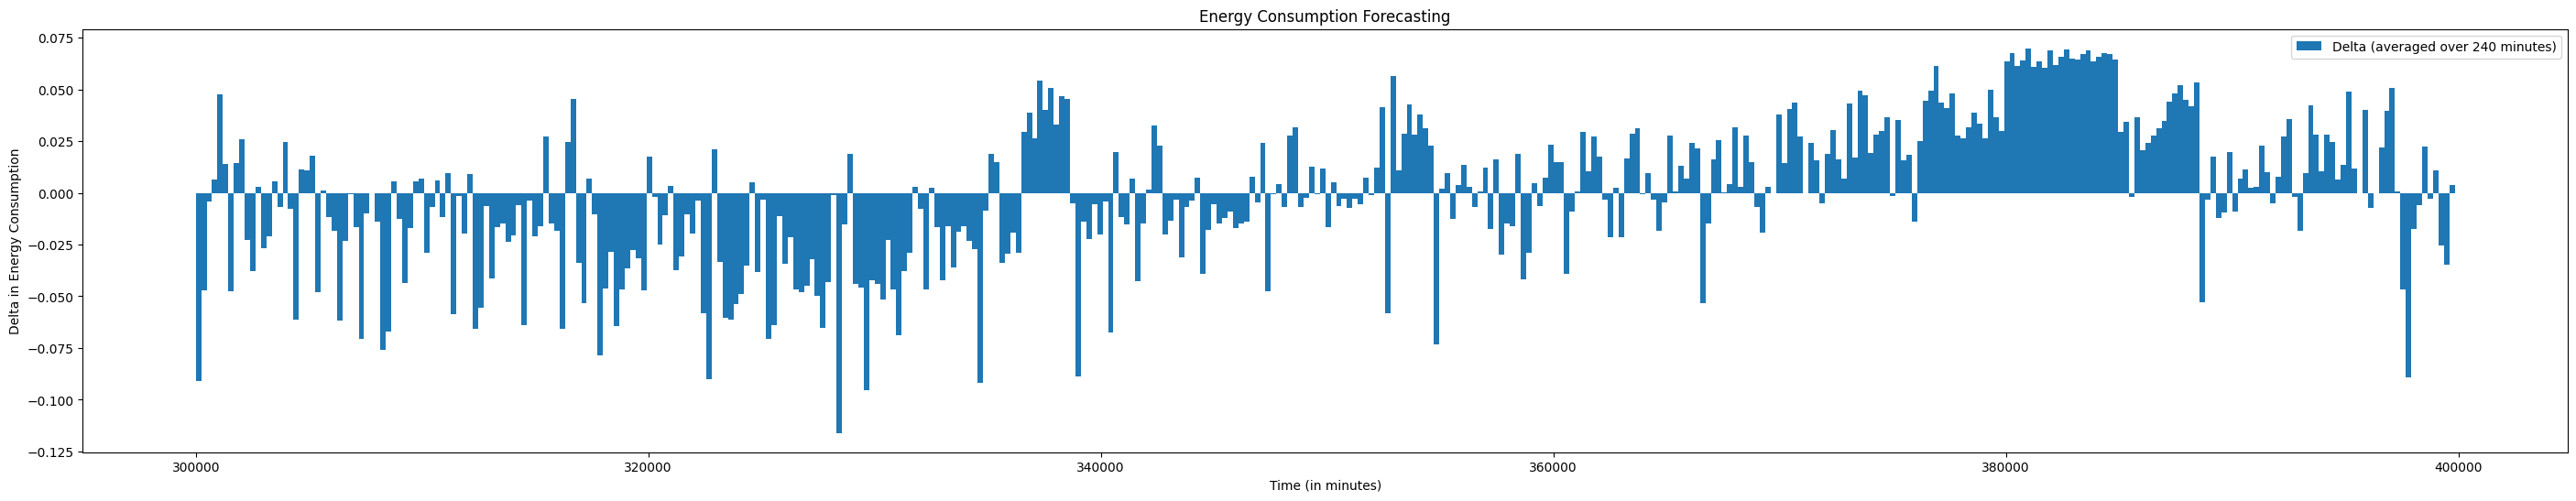

In [17]:

# Model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.squeeze().cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mse = mean_squared_error(actuals, predictions)
    print(f"Test MSE: {mse}")
    return actuals, predictions, mse

actuals, predictions, mse = evaluate_model(model, test_loader)

# Preparing the data for graphing
delta = predictions - actuals
x_start = 300_000
x_end = 400_000
delta_slice = delta[x_start:x_end]
actuals_slice = actuals[x_start:x_end]
positive_delta = np.maximum(delta_slice, 0)
negative_delta = np.minimum(delta_slice, 0)
x_values = range(x_start, x_end)

# Grouping data in chunks
chunk_size = 240
num_chunks = len(delta_slice) // chunk_size
averaged_actuals = [np.mean(actuals_slice[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
averaged_deltas = [np.mean(delta_slice[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
averaged_positive_deltas = [np.mean(positive_delta[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
averaged_negative_deltas = [np.mean(negative_delta[i * chunk_size:(i+1) * chunk_size]) for i in range(num_chunks)]
x_values = range(x_start, x_start + num_chunks * chunk_size, chunk_size)

# Stacked barplot: Actuals +- Delta
plt.figure(figsize=(35, 6))
plt.bar(x_values, averaged_actuals, width=chunk_size, align="edge", label=f"Delta (averaged over {chunk_size} minutes)", color="dodgerblue")
plt.bar(x_values, averaged_positive_deltas, width=chunk_size, align="edge", bottom=averaged_actuals, label="Positive Delta", color="orange")
plt.bar(x_values, averaged_negative_deltas, width=chunk_size, align="edge", bottom=np.array(averaged_actuals) + np.array(averaged_positive_deltas), label="Negative Delta", color="red")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time (in minutes)")
plt.ylabel("Delta in Energy Consumption")
plt.savefig("rnn_loss_barplot.png")

# Barplot: Delta
plt.figure(figsize=(35, 6))
plt.bar(x_values, averaged_deltas, width=chunk_size, align="edge", label=f"Delta (averaged over {chunk_size} minutes)")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time (in minutes)")
plt.ylabel("Delta in Energy Consumption")
plt.savefig("rnn_loss_delta.png")
